In [1]:
import pandas as pd
import numpy as np
import logging
import time 
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.spatial import distance
from scipy.stats import bootstrap

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the .pkl files

In [2]:
df_train = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_train_data.pkl")
df_test = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_test_data.pkl")

### \#1: Using Cosine Similarity as a Proxy Predictor

In [3]:
cos_sim = nn.CosineSimilarity(dim=0)
df_test['cosine_similarity'] = df_test.apply(lambda x: cos_sim(x.biobert_embedding_1, x.biobert_embedding_2), axis=1)
df_test.head(5)

,idx,variable_description_1,concept_name_1,study_1,variable_description_2,concept_name_2,study_2,match,biobert_embedding_1,biobert_embedding_2,cosine_similarity
1,1,Atrial fibrillation,AFIB,ARIC,time to incident af,AFIB,ARIC,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.2017), tensor(-0.1166), tensor(-0.38...",tensor(0.7178)
3,3,Atrial fibrillation,AFIB,ARIC,ATRIAL FIBRILLATION,AFIB,Framingham,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.1640), tensor(0.1292), tensor(0.2356...",tensor(1.)
6,6,Atrial fibrillation,AFIB,ARIC,ECG-ATRIAL FIBRILLATION,AFIB,Framingham,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.3071), tensor(-0.1571), tensor(0.261...",tensor(0.9368)
11,11,Atrial fibrillation,AFIB,ARIC,Atrial Fibrillation (via ICD10 Code): Time fro...,AFIB,MESA,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.3229), tensor(-0.1879), tensor(0.095...",tensor(0.8597)
16,16,Atrial fibrillation,AFIB,ARIC,"TIME BETWEEN FIRST AND FIFTH VISITS, IN DAYS",AFIB,MESA,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.3109), tensor(-0.0889), tensor(-0.12...",tensor(0.7348)


In [4]:
# plot the ROC
from sklearn import metrics

preds = df_test.cosine_similarity.to_list()
preds = [i.detach().cpu().numpy() for i in preds]

gt_labels = df_test.match.to_list()

fpr, tpr, _ = metrics.roc_curve(gt_labels, preds)
auc = metrics.roc_auc_score(gt_labels, preds)

In [5]:
with open('./visualization/baseline_preds.pkl', 'wb') as wfile:
    pickle.dump(preds, wfile)
with open('./visualization/baseline_gt_labels.pkl', 'wb') as wfile:
    pickle.dump(gt_labels, wfile)

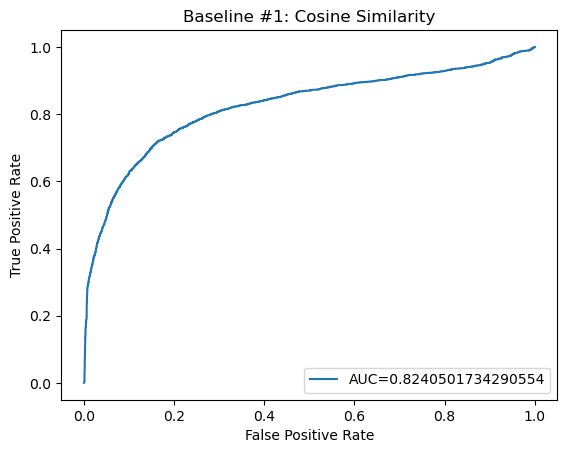

In [6]:
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Baseline #1: Cosine Similarity')
plt.legend(loc=4)
plt.show()

#### Per-concept AUC

In [7]:
concepts = df_test.concept_name_1.unique()
mauc_ovr = {}
for concept in concepts:
    df_concept = df_test[(df_test['concept_name_1'] == concept) | (df_test['concept_name_2'] == concept)]
    # print(df_concept.shape)
    preds = df_concept.cosine_similarity.to_list()
    preds = [i.detach().cpu().numpy() for i in preds]

    gt_labels = df_concept.match.to_list()

    fpr, tpr, _ = metrics.roc_curve(gt_labels, preds)
    try: 
        mauc_ovr[concept] = metrics.roc_auc_score(gt_labels, preds)
        print("AUC for", concept, " : ", mauc_ovr[concept])
    except ValueError as e:
        print(concept, ": ", e)

AUC for AFIB  :  0.5940347970173985
AUC for AGE  :  0.9676829268292683
AUC for ALCOHOL  :  0.8357446808510638
AUC for ANYCHOLMED  :  0.7395983980420515
AUC for ASPIRIN  :  0.6667520054616829
AUC for BASE_CVD  :  0.6944444444444444
AUC for BASE_STROKE  :  0.70625
AUC for BG  :  0.7795275590551182
AUC for BMI  :  0.7665401748886322
AUC for CARSTEN  :  0.6933158584534731
AUC for CENSDAY  :  0.9722222222222223
AUC for CREAT  :  0.8900452488687783
AUC for CURRSMK  :  0.922702796595449
AUC for DEATH_IND  :  0.9387755102040817
AUC for DIAB  :  0.8318557919621751
AUC for DIABP  :  0.7595473833097595
AUC for DIABP1  :  0.971774193548387
AUC for DIABP2  :  0.8849206349206349
AUC for EDUCLEV  :  0.14893617021276595
AUC for EVENT_DESC  :  0.4444444444444444
AUC for EVENT_T2_O  :  0.9480122324159022
AUC for EVENT_VAL_C  :  0.6
AUC for FAM_INCOME  :  0.5727272727272728
AUC for FASTING_12HR  :  0.3414634146341463
AUC for FASTING_8HR  :  1.0
AUC for FASTING_BG  :  0.9847972972972973
AUC for FH_STROKE 

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true

In [8]:
with open('./visualization/baseline_mauc_ovr.pkl', 'wb') as wfile:
    pickle.dump(mauc_ovr, wfile)

### \#2: Logistic Regression

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [10]:
df_train['cosine_similarity'] = df_train.apply(lambda x: cos_sim(x.biobert_embedding_1, x.biobert_embedding_2), axis=1)

In [11]:
log_reg = LogisticRegression()
log_reg.fit(df_train['cosine_similarity'].to_numpy().reshape(-1, 1), df_train['match'].to_numpy())

LogisticRegression()

In [12]:
y_pred_logreg = log_reg.predict_proba(df_test['cosine_similarity'].to_numpy().reshape(-1, 1))[:, 1]

fpr, tpr, _ = metrics.roc_curve(df_test['match'].to_numpy(), y_pred_logreg)
auc = metrics.roc_auc_score(df_test['match'].to_numpy(), y_pred_logreg)

In [13]:
with open('./visualization/baseline_logreg_preds.pkl', 'wb') as wfile:
    pickle.dump(y_pred_logreg, wfile)
with open('./visualization/baseline_logreg_gt_labels.pkl', 'wb') as wfile:
    pickle.dump(df_test['match'].to_numpy(), wfile)

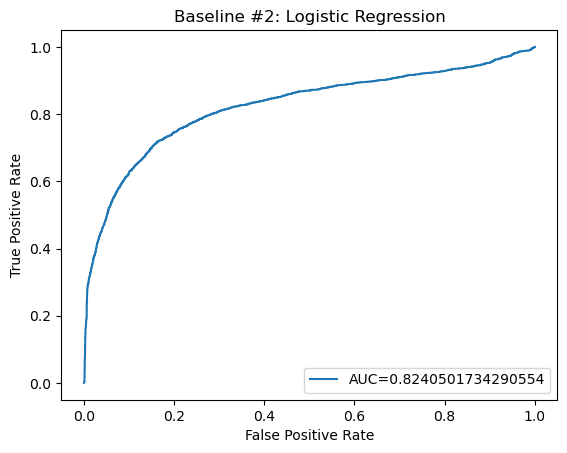

In [14]:
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Baseline #2: Logistic Regression')
plt.legend(loc=4)
plt.show()

In [15]:
concepts = df_test.concept_name_1.unique()
mauc_ovr = {}
pc_aucs = []
for concept in concepts:
    df_concept = df_test[(df_test['concept_name_1'] == concept) | (df_test['concept_name_2'] == concept)]
    # print(df_concept.shape)
    preds = log_reg.predict_proba(df_concept['cosine_similarity'].to_numpy().reshape(-1, 1))[:, 1]

    gt_labels = df_concept.match.to_list()

    fpr, tpr, _ = metrics.roc_curve(gt_labels, preds)
    try: 
        mauc_ovr[concept] = metrics.roc_auc_score(gt_labels, preds)
        pc_aucs.append(metrics.roc_auc_score(gt_labels, preds))
        print("AUC for", concept, " : ", mauc_ovr[concept])
    except ValueError as e:
        print(concept, ": ", e)

AUC for AFIB  :  0.5940347970173985
AUC for AGE  :  0.9676829268292683
AUC for ALCOHOL  :  0.8357446808510638
AUC for ANYCHOLMED  :  0.7395983980420515
AUC for ASPIRIN  :  0.6667520054616829
AUC for BASE_CVD  :  0.6944444444444444
AUC for BASE_STROKE  :  0.70625
AUC for BG  :  0.7795275590551182
AUC for BMI  :  0.7665401748886322
AUC for CARSTEN  :  0.6933158584534731
AUC for CENSDAY  :  0.9722222222222223
AUC for CREAT  :  0.8900452488687783
AUC for CURRSMK  :  0.922702796595449
AUC for DEATH_IND  :  0.9387755102040817
AUC for DIAB  :  0.8318557919621751
AUC for DIABP  :  0.7595473833097595
AUC for DIABP1  :  0.971774193548387
AUC for DIABP2  :  0.8849206349206349
AUC for EDUCLEV  :  0.14893617021276595
AUC for EVENT_DESC  :  0.4444444444444444
AUC for EVENT_T2_O  :  0.9480122324159022
AUC for EVENT_VAL_C  :  0.6
AUC for FAM_INCOME  :  0.5727272727272728
AUC for FASTING_12HR  :  0.3414634146341463
AUC for FASTING_8HR  :  1.0
AUC for FASTING_BG  :  0.9847972972972973
AUC for FH_STROKE 

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true

In [16]:
pd.DataFrame(pc_aucs).describe()

,0
count,56.000000
mean,0.772880
std,0.177122
min,0.148936
25%,0.675116
50%,0.814450
75%,0.908171
max,1.000000


In [17]:
# violin plot
violin_concepts = []
violin_match = []
violin_pred = []

inf_df = df_test
inf_preds = pd.DataFrame({
    "idx": df_test['idx'],
    "match": df_test['match'],
    "predict_proba": y_pred_logreg
})
inf_df = inf_df.merge(inf_preds, on=['idx', 'match'], how='inner')

concepts = inf_df.concept_name_1.unique()
print(len(concepts))
for concept in concepts:
    match_inf_conc = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)][['concept_name_1','concept_name_2', 'match', 'predict_proba']]
    match_inf_conc['concept_name'] = match_inf_conc['concept_name_1'] + "," + match_inf_conc['concept_name_2']
    match_inf_conc['concept_name'] = match_inf_conc['concept_name'].str.split(",")
    match_inf_conc = match_inf_conc.explode('concept_name')
    match_inf_conc = match_inf_conc.drop(columns=['concept_name_1', 'concept_name_2'])
    match_inf_conc = match_inf_conc.drop_duplicates().reset_index(drop=True)
    violin_concepts.append(match_inf_conc['concept_name'].values)
    violin_match.append(match_inf_conc['match'].values)
    violin_pred.append(match_inf_conc['predict_proba'].values)
    
violin_df = pd.DataFrame({
    "concept": np.concatenate(violin_concepts).tolist(),
    "match": np.concatenate(violin_match).tolist(),
    "predict_proba": np.concatenate(violin_pred).tolist()
})
print(violin_df.shape)
violin_df = violin_df.sort_values("concept")

violin_df.to_pickle('./visualization/baseline_violin_df.pkl')

61
(37219, 3)


<AxesSubplot:xlabel='predict_proba', ylabel='concept'>

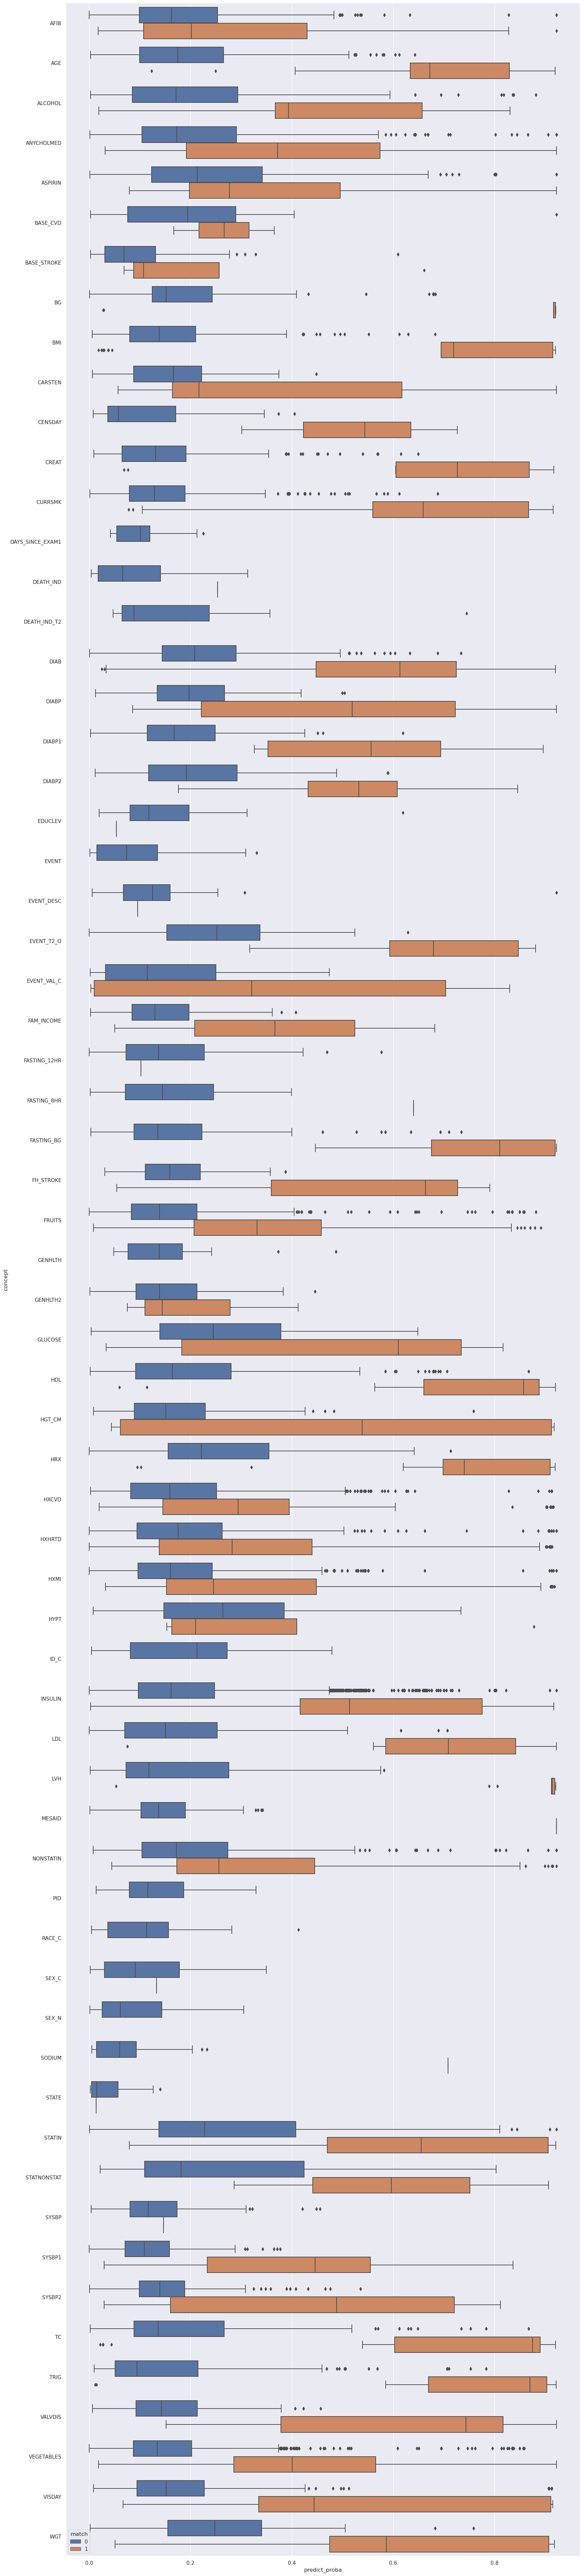

In [18]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 100)})
sns.boxplot(data=violin_df, x="predict_proba", y="concept", hue="match")

In [19]:
# prepare a custom function for prediction given a sentence
# ensure protobuf = 3.20.x
from biobert_embedding.embedding import BiobertEmbedding

2024-04-29 00:14:34.109924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 00:14:35.015437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-04-29 00:14:35.015562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-04-29 00:14:35.015575: W tensorflow/compiler/tf2tensorrt/utils/py_u

In [20]:
df_p = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/predictor_data.pkl")
df_p = df_p.reset_index(drop=True)

# prepare the predictor dataset
df_p_dict = {}
p_concepts = df_p[df_p['study'] == 'None']['concept'].values
p_concepts_embeds = df_p[df_p['study'] == 'None']['biobert_embedding'].values

biobert = BiobertEmbedding(model_path='/mnt/workspace/pratheek/packages/biobert/')

class ConceptPredictor:
    def __init__(self, concepts, concepts_embeds):
        self.concepts = concepts
        self.concepts_embeds = concepts_embeds

    def baseline(self, sentence):
        sent_embed = biobert.sentence_vector(sentence)
        input1 = [sent_embed for i in range(len(self.concepts_embeds))]
        input2 = [concept_embed for concept_embed in self.concepts_embeds]
        cos_sim = nn.CosineSimilarity(dim=0)
        pred_df = pd.DataFrame({
            'concept_name': self.concepts,
            'biobert_embedding_1': input1,
            'biobert_embedding_2': input2
        })
        pred_df['cosine_similarity'] = pred_df.apply(lambda x: cos_sim(x.biobert_embedding_1, x.biobert_embedding_2).numpy(), axis=1)
        pred_df['predict_proba'] = pred_df.apply(lambda x: log_reg.predict_proba(x.cosine_similarity.reshape(-1, 1)).ravel()[1], axis=1)
        # pred_df['predict_score'] = pred_df['predict_proba'].values[1]
        pred_df = pred_df.drop(columns=['biobert_embedding_1', 'biobert_embedding_2']).sort_values(by=['predict_proba'], ascending=False)
        
        return pred_df
CPred = ConceptPredictor(p_concepts, p_concepts_embeds)

In [21]:
pdf1 = CPred.baseline("ECG: RHYTHM")
pdf1

,concept_name,cosine_similarity,predict_proba
11,CURRSMK,0.85236317,0.373125
36,HXCVD,0.85200137,0.371411
27,FASTING_BG,0.8453882,0.340680
18,DIABP2,0.84490925,0.338502
26,FASTING_8HR,0.8438038,0.333501
...,...,...,...
32,GLUCOSE,0.71754974,0.037237
1,ALCOHOL,0.71450764,0.035088
29,FRUITS,0.71361685,0.034482
59,VEGETABLES,0.6829248,0.018806


In [22]:
# get the top1 and top5 accuracy
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.baseline(row['variable_description'])
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [23]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  11.2988
top5 accuracy:  20.8025


In [64]:
# CI AUC
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = y_pred_logreg
y_test = df_test['match'].to_numpy()
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(y_test[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([0.81461466, 0.83396217])

In [62]:
# CI top-1
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top1
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([ 9.5037, 13.3052])

In [63]:
# CI top-5
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top5
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([18.3738, 23.4424])